In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=54995fdc73ca32e14d51ba44a7c9b9f06f61c3465047a614a15134829109649f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
import pandas as pd
import pandas_ta as ta

# Load the data
df = pd.read_csv('dataset.csv')

# Calculate Moving Averages
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# Calculate Exponential Moving Averages
df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Calculate RSI
df['RSI14'] = ta.rsi(df['Close'], length=14)

# Calculate MACD and Signal line
macd = ta.macd(df['Close'])
df['MACD'] = macd['MACD_12_26_9']
df['Signal'] = macd['MACDs_12_26_9']

# Drop NaN values (due to indicator calculation on initial rows)
df = df.dropna()

# Save the modified dataset
df.to_csv('dataset_with_indicators.csv', index=False)


Trial 10 Complete [00h 00m 40s]
val_loss: 0.0006588135147467256

Best val_loss So Far: 0.00044406342203728855
Total elapsed time: 00h 06m 46s
3/3 [==============================] - 1s 18ms/step
Mean Squared Error (MSE): 51.26325360603585
Root Mean Squared Error (RMSE): 7.159836143797975
Mean Absolute Error (MAE): 6.1054371221177375
R-squared (R²) Score: 0.7080784183927074
Mean Absolute Percentage Error (MAPE): 11.404604348513638%


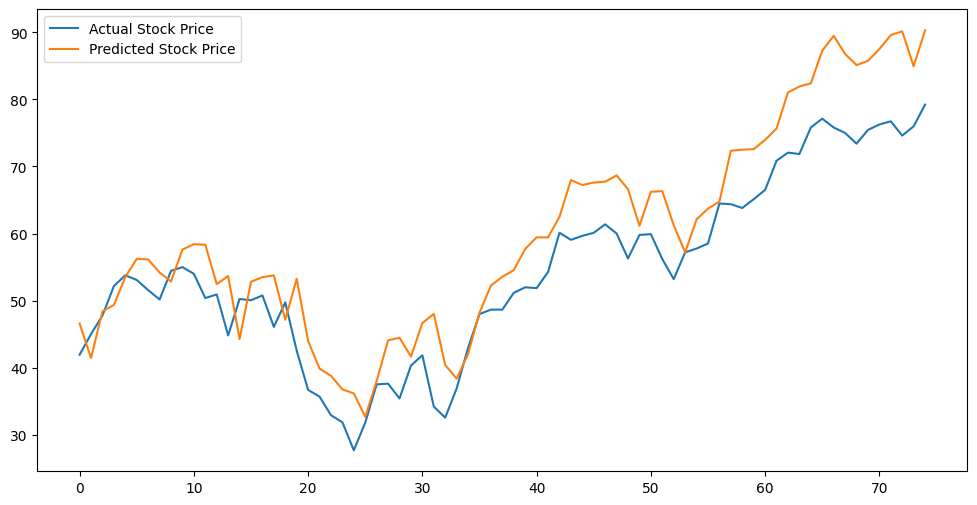

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel
import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    # Include the new indicators
    data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'fear-greed', 'MA10',
               'MA20', 'EMA10', 'EMA20', 'RSI14', 'MACD', 'Signal']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 3])  # Index 3 corresponds to the 'Close' price
    return np.array(x), np.array(y)

file_path = 'dataset_with_indicators.csv'  # Use the modified dataset
data, scaler = load_data(file_path)

time_step = 60  # Number of time steps to look back
x, y = create_dataset(data, time_step)
x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))

# Split data into train, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size - time_step:train_size + val_size]
test_data = data[train_size + val_size - time_step:]

x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Define the model for Keras Tuner
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32), return_sequences=False))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=128, step=16)))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

# Perform hyperparameter tuning with Keras Tuner
tuner = RandomSearch(
    LSTMHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='stock_prediction'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
predictions = best_model.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], data.shape[1]-1)), predictions], axis=1))[:, -1]

# Inverse transform y_test
y_test = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

# Optional: Visualize predictions and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price')
plt.plot(predictions, label='Predicted Stock Price')
plt.legend()
plt.show()